In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Load the data

image_folder = "/content/drive/MyDrive/Linknet/images"
mask_folder = "/content/drive/MyDrive/Linknet/masks"
label_folder = "/content/drive/MyDrive/Linknet/labels"

In [ ]:
# Load images
images = []
img_file=os.listdir(image_folder)
for i in img_file:
    img = cv2.imread(os.path.join(image_folder,i))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)

In [ ]:
# Load masks
masks = []
mask_file=os.listdir(mask_folder)
for i in mask_file:
    mask = cv2.imread(os.path.join(mask_folder,i))
    # mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
    masks.append(mask)

In [ ]:
masks_gray = []
for mask in masks:
    gray_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    masks_gray.append(gray_mask)

masks_gray = np.array(masks_gray)


In [ ]:
# Data pre-processing

# Resize images and masks to a uniform size
IMG_HEIGHT = 256
IMG_WIDTH = 256
images_resized = [cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) for img in images]
masks_resized = [cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH)) for mask in masks_gray]

# Normalize images
images_normalized = [img.astype(np.float32) / 255.0 for img in images_resized]
masks_normalized = [mask.astype(np.float32) / 255.0 for mask in masks_resized]

# Convert the list of images to a 4D numpy array
images_normalized = np.array(images_normalized)
masks_normalized=np.array(masks_normalized)

masks_normalized = np.expand_dims(masks_normalized, axis=-1)

In [ ]:
print(masks_gray.shape)
print(images_normalized.shape)
print(masks_normalized.shape)

(38, 1024, 1024)
(38, 256, 256, 3)
(38, 256, 256, 1)


In [ ]:
n_augmentations = 100
batch_size = 10

# Create an ImageDataGenerator object with augmentation settings
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect')

# Fit the ImageDataGenerator to your images
datagen.fit(images_normalized)

# Create a new list to store the augmented images
augmented_images = []

# Generate augmented images in smaller batches and add them to the list
n_batches = int(np.ceil(n_augmentations * len(images_normalized) / batch_size))
for i in range(n_batches):
    batch = datagen.flow(images_normalized, batch_size=batch_size, shuffle=True, seed=42).__next__()
    augmented_images.extend(batch)
    if len(augmented_images) >= len(images_normalized) * n_augmentations:
        break

# Convert the list of augmented images to a NumPy array
augmented_images = np.array(augmented_images)


In [ ]:
# Fit the ImageDataGenerator to your masks
datagen.fit(masks_normalized)

# Create a new list to store the augmented masks
augmented_masks = []

# Generate augmented masks in smaller batches and add them to the list
n_batches = int(np.ceil(n_augmentations * len(masks_normalized) / batch_size))
for i in range(n_batches):
    batch = datagen.flow(masks_normalized, batch_size=batch_size, shuffle=True, seed=42).__next__()
    augmented_masks.extend(batch)
    if len(augmented_masks) >= len(masks_normalized) * n_augmentations:
        break

# Convert the list of augmented images to a NumPy array
augmented_masks = np.array(augmented_masks)

In [ ]:
print(augmented_images.shape)
print(augmented_masks.shape)

(3800, 256, 256, 3)
(3800, 256, 256, 1)


In [ ]:
# convert mask images to one-hot encoded format
masks_onehot = [keras.utils.to_categorical(mask, num_classes=2, dtype=np.uint8) for mask in augmented_masks]

In [ ]:
#Build the LinkNet model

def linknet(input_shape):
    # Encoder
    input_layer = keras.layers.Input(shape=input_shape)
    conv1 = keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(conv1)
    conv1 = keras.layers.BatchNormalization()(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(pool1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(conv2)
    conv2 = keras.layers.BatchNormalization()(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same')(pool2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same')(conv3)
    conv3 = keras.layers.BatchNormalization()(conv3)
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = keras.layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='same')(pool3)
    conv4 = keras.layers.BatchNormalization()(conv4)
    conv4 = keras.layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='same')(conv4)
    conv4 = keras.layers.BatchNormalization()(conv4)

    # Decoder
    up1 = keras.layers.UpSampling2D(size=(2, 2))(conv4)
    up1 = keras.layers.concatenate([up1, conv3], axis=-1)
    conv5 = keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same')(up1)
    conv5 = keras.layers.BatchNormalization()(conv5)
    conv5 = keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same')(conv5)
    conv5 = keras.layers.BatchNormalization()(conv5)

    up2 = keras.layers.UpSampling2D(size=(2, 2))(conv5)
    up2 = keras.layers.concatenate([up2, conv2], axis=-1)
    conv6 = keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(up2)
    conv6 = keras.layers.BatchNormalization()(conv6)
    conv6 = keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(conv6)
    conv6 = keras.layers.BatchNormalization()(conv6)

    up3 = keras.layers.UpSampling2D(size=(2, 2))(conv6)
    up3 = keras.layers.concatenate([up3, conv1], axis=-1)
    conv7 = keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(up3)
    conv7 = keras.layers.BatchNormalization()(conv7)
    conv7 = keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(conv7)
    conv7 = keras.layers.BatchNormalization()(conv7)

    # Output layer
    output_layer = keras.layers.Conv2D(filters=2, kernel_size=1, activation='softmax')(conv7)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

In [ ]:
# Define the model inputs and outputs
input_shape = (256, 256, 3)
inputs = keras.layers.Input(shape=input_shape)
outputs = linknet(input_shape)(inputs)

# Create the model
model = keras.models.Model(inputs=inputs, outputs=outputs)

# Compile the model with the appropriate optimizer and loss function
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
#               loss=keras.losses.CategoricalCrossentropy(from_logits=True),
#               metrics=[keras.metrics.CategoricalAccuracy()])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'], run_eagerly=True)

In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(augmented_images, masks_onehot, test_size=0.3, random_state=42)

In [ ]:
# Train the model
model.fit(
    np.array(X_train), np.array(y_train),
    batch_size=16,
    epochs=10,
    validation_data=(np.array(X_val), np.array(y_val))
)


In [ ]:
model.save('/content/drive/MyDrive/Linknet/model.h5')
model.save_weights('/content/drive/MyDrive/Linknet/model_weights.h5')



1/1 [==============================] - 2s 2s/step


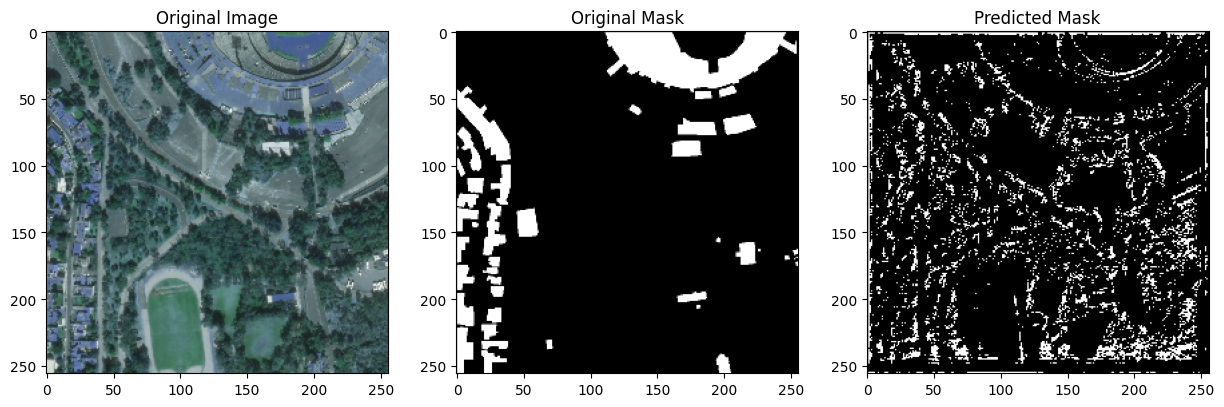

In [ ]:

# Load the image and mask
img = cv2.imread('/content/drive/MyDrive/Linknet/images/mexico-earthquake_00000095_pre_disaster.png')
mask = cv2.imread('/content/drive/MyDrive/Linknet/masks/mexico-earthquake_00000095_pre_disaster.png', cv2.IMREAD_GRAYSCALE)

# Resize the image and mask to the desired size
img = cv2.resize(img, (256, 256))
mask = cv2.resize(mask, (256, 256))

# Normalize the image and mask
img_normalized = img / 255.0
mask_normalized = mask / 255.0

# Add a batch dimension to the image and mask
img_normalized = np.expand_dims(img_normalized, axis=0)
mask_normalized = np.expand_dims(mask_normalized, axis=0)
mask_normalized = np.expand_dims(mask_normalized, axis=-1)

# Predict the mask using the model
predicted_mask = model.predict(img_normalized)

# Convert the predicted mask to an RGB image
predicted_mask = predicted_mask[0]
predicted_mask = np.argmax(predicted_mask, axis=-1)
predicted_mask = predicted_mask.astype(np.uint8)
predicted_mask *= 255
predicted_mask = cv2.cvtColor(predicted_mask, cv2.COLOR_GRAY2RGB)

# Plot the original image, mask, and predicted mask
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
ax = axes.ravel()

ax[0].imshow(img)
ax[0].set_title('Original Image')

ax[1].imshow(mask, cmap='gray')
ax[1].set_title('Original Mask')

ax[2].imshow(predicted_mask)
ax[2].set_title('Predicted Mask')

plt.show()


In [ ]:
def iou_metric(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def f1_metric(y_true, y_pred):
    tp = np.sum(np.logical_and(y_true, y_pred))
    fp = np.sum(np.logical_and(np.logical_not(y_true), y_pred))
    fn = np.sum(np.logical_and(y_true, np.logical_not(y_pred)))
    precision = tp / (tp + fp + 1e-10)
    recall = tp / (tp + fn + 1e-10)
    f1_score = 2 * precision * recall / (precision + recall + 1e-10)
    return f1_score

def error_metric(y_true, y_pred):
    error = np.mean(y_true != y_pred)
    return error


In [ ]:
# Predict the masks for the test images
test_preds = model.predict(img_normalized)

# Convert the predictions to binary masks
test_preds = (test_preds > 0.5).astype(np.uint8)

# Calculate the IOU score
iou = np.mean([iou_metric(mask_normalized[i], test_preds[i]) for i in range(len(img_normalized))])
print("IOU score:", iou)

# Calculate the F score
f_score = np.mean([f1_metric(mask_normalized[i], test_preds[i]) for i in range(len(img_normalized))])
print("F score:", f_score)

# Calculate the error
error = np.mean([error_metric(mask_normalized[i], test_preds[i]) for i in range(len(img_normalized))])
print("Error:", error)


1/1 [==============================] - 2s 2s/step
IOU score: 0.12461263090403933
F score: 0.22160987252022513
Error: 0.5064697265625
